<a href="https://colab.research.google.com/github/anderboni/Projeto_FINAL_Bootcamp_Data_Science/blob/main/Projeto_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROJETO FINAL - Bootcamp Data Science**

*Última atualização em 27/08/2021*


###**Objetivo do projeto**: 
<p align = "justify">"Prever quais pacientes precisarão ser admitidos na unidade de terapia intensiva e assim, definir qual a necessidade de leitos de UTI do hospital, a partir dos dados clínicos individuais disponíveis.".</p>

###**Motivação**:
<p align = "justify">Inicialmente o que nos motiva a realizar este projeto é o próprio desafio proposto no Bootcamp de Data Science da Alura, sendo esta motivação inicial amplificada substancialmente em razão da possibilidde de contribuir com um projeto de cunho prático de um grande hospital. A isso se soma o fato de trabalhar com uma temática que é o foco central da vida de todos, em âmbito mundial, onde a proposta é a tentativa de melhorar uma previsão que, se bem implementada, poderá contribuir para o salvamento de vidas. Embora nosso conhecimento ainda seja inicial e básico a respeito do assunto "Machine Learning", de maneira especifica, e "Data Science", de maneira geral, certamente tentamos fazer o melhor, embora saibamos que muito há para ser melhorado no projeto e que há outras formas de trabalhar a questão proposta.</p>


---
#Importando e preparando os dados

Dados obtidos em https://www.kaggle.com/S%C3%ADrio-Libanes/covid19 às 11 horas do dia 16/08/2021, os quais foram disponibilizados pelo Hospital Sirio Libanes, por meio da plataforma KAGGLE, conforme detalhamento no resumo deste projeto.

In [1]:
#importando os dados disponibilizados no KAGGLE, armazenados no GITHUB

import pandas as pd
import numpy as np

dados = pd.read_excel("https://github.com/anderboni/Projeto_FINAL_Bootcamp_Data_Science/blob/main/Dados/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [2]:
#função para limpar os dados 

def preenche_tabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns #todas as linhas, mas selecionando apenas colunas com variáveis contínuas
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill') #agrupando e completando
    features_categoricas = dados.iloc[:, :13] #variáveis categóricas estão nas colunas 0 a 12
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True, axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

In [3]:
#limpando e preparando os dados, utilizando a função criada

dados_limpos = preenche_tabela(dados)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values #selecionando pacientes que foram para a UTI nas primeiras 2 horas
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover") #excluíndo pacientes que foram para a UTI nas primeiras 2 horas
dados_limpos = dados_limpos.dropna()
dados_limpos.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.33913,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.27272

In [4]:
#função para agrupar as visitas ao paciente e manter a janela de 0-2 (duas primeiras horas)
#iremos trabalhar somente com as informações relativas às primeiras duas horas do paciente no hospital, para que a tomada de decisão seja célere 

def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype("category").cat.codes
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.9

#Análise exploratória dos dados

Iremos agora ralizar uma breve análise dos dados que obtivemos na plataforma KAGGLE.

De início, vamos descrever algumas colunas da base de dados que foram objeto desta análise:

> **AGE_PERCENTIL** = faixa etária do paciente;

> **GENDER** = gênero;

> **IMMUNOCOMPROMISED** - paciente imunocomprometido;

OBS: os valores 0 e 1 indicam respectivamente "não" e "sim" / "masculino" e "feminino".

> **WINDOW** = janela de tempo que indica as medições realizadas junto ao paciente, ao passar das horas, conforme segue:

>> "0-2" = primeiras 2 horas;

>> "2-4" = entre 2 e 4 horas;

>> "4-6" = entre 4 e 6 horas;

>> "6-12" = entre 6 e 12 horas;

>> "ABOVE_12" = acima de 12 horas.






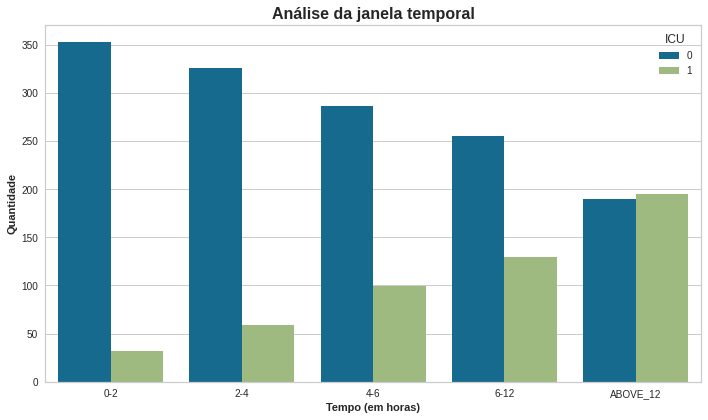

In [58]:
#janela temporal dos pacientes 

plt.figure(figsize=(10,6))
plt.title("Análise da janela temporal", fontsize=16, fontweight="bold")
sns.countplot(dados["WINDOW"], hue="ICU", data=dados)
plt.ylabel("Quantidade", fontweight='bold')
plt.xlabel("Tempo (em horas)",fontweight='bold')
plt.tight_layout()

<p align = "justify">No gráfico acima verificamos a janela temporal presente nos dados disponibilizados pelo hospital, na íntegra, antes de realizarmos a "limpeza" inicial. Optamos por trabalhar apenas com a janela (window) de 0-2, ou seja, as primeiras duas horas do paciente no hospital. Isso, entendemos, é crucial para determinar o mais cedo possível a propensão de um paciente ir (1) ou não ir (0) para a UTI. No gráfico é possível verificar que a chance de um paciente ir para a UTI aumenta com o passar do tempo (barra verde), tornando assim mais robusta a tese da necessidade de concentrar os esforços na análise dos dados obtidos nas primeiras horas, a fim de, com estas informações, realizar a previsão por meio do modelo.</p>

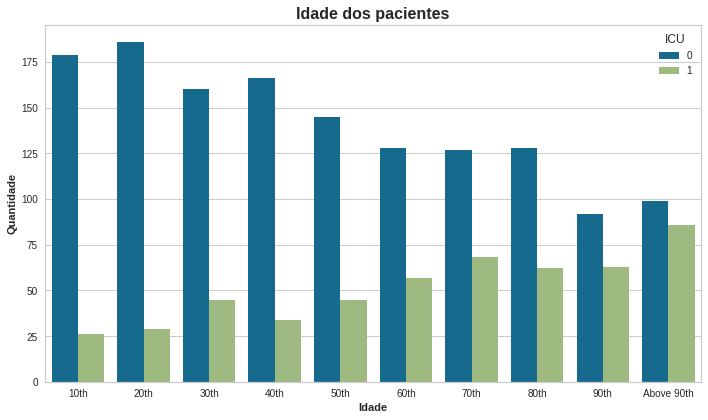

In [69]:
#idade dos pacientes que foram para a UTI

plt.figure(figsize=(10,6))
plt.title("Idade dos pacientes", fontsize=16, fontweight="bold")
sns.countplot(dados["AGE_PERCENTIL"].sort_values(ascending=True), hue="ICU", data=dados)
plt.ylabel("Quantidade", fontweight='bold')
plt.xlabel("Idade",fontweight='bold')
plt.tight_layout()

<p align = "justify">Verifica-se, por meio do gráfico acima, que quanto maior a idade do paciente, maior a tendência dele necessitar de um leito de UTI, principalmente para pacientes acima de 90 anos, o que já era de certa forma esperado.</p>

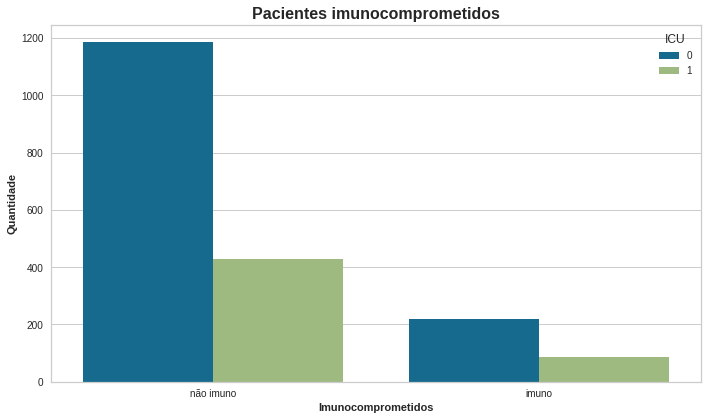

In [80]:
#pacientes imunocomprometidos que foram para a UTI

import matplotlib.ticker as ticker

plt.figure(figsize=(10,6))
plt.title("Pacientes imunocomprometidos", fontsize=16, fontweight="bold")
ax = sns.countplot(dados["IMMUNOCOMPROMISED"], hue="ICU", data=dados)
ax.xaxis.set_major_formatter(ticker.FixedFormatter(["não imuno", "imuno"]))
plt.ylabel("Quantidade", fontweight='bold')
plt.xlabel("Imunocomprometidos",fontweight='bold')
plt.tight_layout()

<p align = "justify">A partir do gráfico acima é possível verficar que a quantidade de imunocomprometidos internados é superior ao de não-imunocomprometidos, guardadas as devidas proporções entre ambos. Portanto, esta torna-se uma variável importante de ser incluída na modelagem.</p>

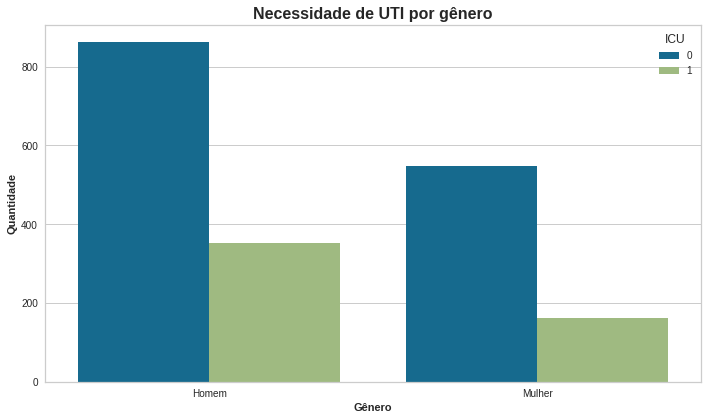

In [79]:
#necessidade de UTI por gênero

plt.figure(figsize=(10,6))
plt.title("Necessidade de UTI por gênero", fontsize=16, fontweight="bold")
ax = sns.countplot(dados["GENDER"], hue="ICU", data=dados)
ax.xaxis.set_major_formatter(ticker.FixedFormatter(["Homem", "Mulher"]))
plt.ylabel("Quantidade", fontweight='bold')
plt.xlabel("Gênero",fontweight='bold')
plt.tight_layout()

<p align = "justify">Conforme visto acima, a quantidade de internações por gênero, embora pareça proporcional entre homens e mulheres, é levemente superior para os homens, ou seja, os homens, aparentemente, possuem maior possibilidade de serem internados em UTI do que as mulheres.</p>

<p align = "justify">Estas foram apenas algumas análises realizadas com a intenção de oferecer uma visão panorâmica dos dados que iremos submeter aos modelos, na sequência. Muitas outras análises certamente poderiam ter sido realizadas, sendo que um aprofundamento nessa exploração de dados é altamente recomendada, não somente para facilitar a compreensão do estudo em si, mas também para direcionar de maneira mais adequada a própria implementação dos modelos de Machine Learning.</p>

---
#Testando a implementação de quatro modelos de Machine Learning

<p align = "justify">Neste projeto utilizaremos três modelos que foram explorados ao longo das aulas do curso, além de um modelo adicional que escolhemos para compor os testes.</p> 

<p align = "justify">Neste caso em específico, necessitamos utilizar algorítimos de classificação, em função do problema proposto. O resultado do modelo será necessariamente uma variável categórica, no caso 0 ou 1, significando respectivamente "não ir" ou "ir" para a UTI, com relação ao paciente.</p>

<p align = "justify">Dividiremos esta fase em duas etapas, a fim de trabalhar inicialmente com os dados minimamente alterados, e com todas as colunas, tal como recebidos do Hospital Sirio Libanes e, posteriormente, eliminando os dados que possuem alta correlação, a fim de tentar otimizar os resultados da máquina preditiva.</p>


##1ª ETAPA: teste sem alteração na base de dados

In [6]:
#importando bibliotecas

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate  
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import seaborn as sns
from yellowbrick.classifier import ROCAUC

import warnings
warnings.filterwarnings('ignore') #para não mostrar alertas no código

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Os quatro modelos que serão utilizados são os seguintes:

In [7]:
#ajustando as variáveis para os modelos

modelo_LR = LogisticRegression(max_iter=10000) #valor de "max_iter" em que melhor se ajustaram os dados em tentativas manuais
modelo_DTC = DecisionTreeClassifier() 
modelo_RFC = RandomForestClassifier() 
modelo_ETC = ExtraTreesClassifier() 

In [8]:
#criando uma função para rodar os modelos...
#...e para apresentar Acurácia, AUC e Cassification Report de cada modelo

def roda_modelo(modelo, dados):

  y = dados["ICU"] #preparando variáveis de treino e teste para os modelos
  x = dados.drop(["ICU","WINDOW"], axis=1)

  np.random.seed(93578) #gerando uma "semente" para reproduzir novamente os resultados obtidos

  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.15) #o "test_size=0.15" reduz um pouco o conjunto de dados para treino

  modelo.fit(x_train, y_train)
  predicao = modelo.predict(x_test)
  prob_predict = modelo.predict_proba(x_test)

  auc = roc_auc_score(y_test, prob_predict[:,1])
  print(f" Acurácia do Modelo: {(accuracy_score(y_test, predicao))*100 :.2f} %")
  print(f"\n AUC: {auc}")
  print("\n Classification Report:")
  print(classification_report(y_test, predicao)) 

###Rodando os modelos

<p align = "justify">Verificando preliminarmente a Acurácia, AUC e Classification Report dos quatro modelos escolhidos para os testes.</p>

In [9]:
roda_modelo(modelo_LR, dados_limpos)

 Acurácia do Modelo: 64.15 %

 AUC: 0.7014285714285715

 Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68        28
           1       0.64      0.56      0.60        25

    accuracy                           0.64        53
   macro avg       0.64      0.64      0.64        53
weighted avg       0.64      0.64      0.64        53



In [10]:
roda_modelo(modelo_DTC, dados_limpos)

 Acurácia do Modelo: 62.26 %

 AUC: 0.6278571428571429

 Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.54      0.60        28
           1       0.58      0.72      0.64        25

    accuracy                           0.62        53
   macro avg       0.63      0.63      0.62        53
weighted avg       0.63      0.62      0.62        53



In [11]:
roda_modelo(modelo_RFC, dados_limpos)

 Acurácia do Modelo: 67.92 %

 AUC: 0.7407142857142857

 Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        28
           1       0.65      0.68      0.67        25

    accuracy                           0.68        53
   macro avg       0.68      0.68      0.68        53
weighted avg       0.68      0.68      0.68        53



In [12]:
roda_modelo(modelo_ETC, dados_limpos)

 Acurácia do Modelo: 66.04 %

 AUC: 0.7178571428571429

 Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        28
           1       0.64      0.64      0.64        25

    accuracy                           0.66        53
   macro avg       0.66      0.66      0.66        53
weighted avg       0.66      0.66      0.66        53



<p align = "justify">A respeito dos dados acima, é importante mencionar que os valores apresentados na "linha 0" referen-se a pacientes que "não" precisam de UTI. Já os apresentados na "linha 1" dizem respeito a pacientes que necessitam de UTI, segundo o modelo.</p> 

<p align = "justify">Para o caso em estudo os "Falsos Negativos" são mais prejudiciais do que os "Falsos Positivos". Um "Falso Negativo" poderia fazer, na prática, com que um paciente que necessite de UTI não seja transferido para a UTI. Nesse aspecto o indicativo "recall" é muito importante, pois irá nos informa o que está correto de tudo o que estamos falando de negativo.</p>

<p align = "justify">Quanto ao "precision", este é muito útil quando temos um caso em que o "Falso Positivo" é muito pior do que o Falso Negativo.</p>

<p align = "justify">Quanto ao "f1-score", trata-se de uma média harmônica entre o "precision" e o "recall". Vamos usar essa técnica para avaliar, por exemplo, quando temos um caso em que o "Falso Negativo" é muito pior do que o "Falso Positivo" (mesmo exemplo acima, do paciente ir ou não pra UTI). Portanto o "fi-score" é um bom resumo, por ser um combinado entre o "precision" e o "recall", ressaltando que algumas das medidas podem estar muita baixa. Entretanto, alertamos para o fato de que ele não é a única medida que faz isso.</p>


Agora, para facilitar a visualização e entendimento dos resultados iniciais, iremos plotar os gráficos de Matriz de Confusão, onde será possível verificar, mais facilmente, a quantidade de Verdadeiros Positivos e Falsos Positivos, além de Falsos Positivos e Falsos Negativos, em cada modelo.

###Matriz de Confusão

In [13]:
#criando uma função para rodar a Matriz de Confusão

def matriz_confusao(modelo, dados):

  y = dados["ICU"] #preparando variáveis de treino e teste para os modelos
  x = dados.drop(["ICU","WINDOW"], axis=1)

  np.random.seed(93578) #gerando uma "semente" para reproduzir novamente os resultados obtidos

  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.15) #o "test_size=0.15" reduz um pouco o conjunto de dados para treino

  modelo.fit(x_train, y_train)
  predicao = modelo.predict(x_test)

  fig, ax = plt.subplots(figsize=(5, 5))

  plot_confusion_matrix(modelo, x_test, y_test, ax=ax, values_format='.0f')
  ax.set_title("Matriz de Confusão", fontsize=16, fontweight="bold")
  plt.grid(False)
  plt.show()

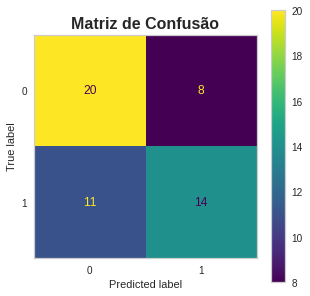

In [14]:
#plotando os valores preditos (usando uma matriz de confusão) - a acurácia é a diagonal
# Modelo Logísitic Regression

matriz_confusao(modelo_LR, dados_limpos)

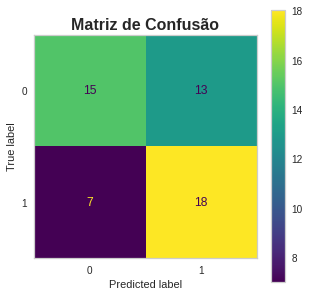

In [15]:
#Modelo Decision Tree

matriz_confusao(modelo_DTC, dados_limpos)

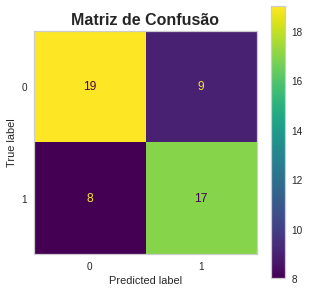

In [16]:
#Modelo Randon Forest

matriz_confusao(modelo_RFC, dados_limpos)

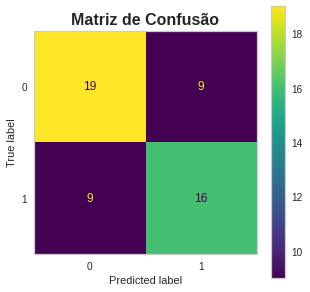

In [17]:
#Modelo Extra Trees

matriz_confusao(modelo_ETC, dados_limpos)

<p align = "justify">Conforme podemos observar nos gráficos acima, os melhores valores associados aos "Verdadeiros Positivos" (amarelo) e "Verdadeiros Negativos" (verde) foram apresentados pelos modelos "Lostistic Regression" e "Randon Forest". Quanto aos "Falsos Positivos" e "Falsos Negativos" (cor violeta), estes ocorreram com maior intensidade nos modelos "Decision Tree" e "Logistic Regression". Mais adiante analisaremos com maiores detalhes essas questões, pois estes dados possuem grande importância no caso em estudo, uma vez que um "Falso Negativo", por exemplo, poderia sugerir enviar para casa um paciente que necessitaria de um leito de UTI, conforme já visto acima.</p>

###Reduzindo os efeitos da aleatoriedade

<p align = "justify">A fim de tentar reduzir os efeitos da aleatoriedade, vamos criar uma função para separar os dados em "train" e "test" diversas vezes (n vezes) e rodar o modelo. Usaremos a métrica AUC (área sob a curva) que separa as pessoas doentes das pessoas não doentes.</p>


In [18]:
#criando a função para reduzir a aleatoriedade

def roda_n_modelos(modelo, dados, n):

  np.random.seed(93578) #garantindo a reprodutibilidade

  y = dados["ICU"]
  x = dados.drop(["ICU","WINDOW"], axis=1)

  auc_lista = [] #definindo nossa lista

  for _ in range(n): #o _ é utilizado em python quando criamos uma variável que não iremos utilizar
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y) 
    modelo.fit(x_train, y_train)
    prob_predict = modelo.predict_proba(x_test) #retorna a possibildiade de eu estar classificando o meu x_test
    auc = roc_auc_score(y_test, prob_predict[:,1]) #pegando todas as linhas da segunda coluna 
    auc_lista.append(auc) #fazendo um "append" em uma lista de resutlados "auc"
   
  auc_medio = np.mean(auc_lista)  
  auc_std = np.std(auc_lista) #calculando o desvio padrão
  print(f" AUC {auc_medio}")
  print(f"\nINtervalo {auc_medio - 2* auc_std} - {auc_medio + 2* auc_std}") #calculando intervalo em que estão 95% dos nossos testes
  return modelo

In [19]:
#rodando e testando agora com o modelo de regressão logística

roda_n_modelos(modelo_LR, dados_limpos, 10)

 AUC 0.7532433834976648

INtervalo 0.697097381706509 - 0.8093893852888207


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
#rodando com o modelo de árvore de decisão

roda_n_modelos(modelo_DTC, dados_limpos, 10)

 AUC 0.613207057602491

INtervalo 0.4956201556512627 - 0.7307939595537192


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [21]:
#rodando com o modelo random forest

roda_n_modelos(modelo_RFC, dados_limpos, 10)

 AUC 0.7941619097042034

INtervalo 0.7099919087690727 - 0.8783319106393341


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
#rodando com o modelo extra trees

roda_n_modelos(modelo_ETC, dados_limpos, 10)

 AUC 0.7908925791385574

INtervalo 0.7082558479988075 - 0.8735293102783073


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

<p align = "justify">Após rodar os modelos "n vezes", é possível notar uma leve melhora em quase todos os casos, quando comparados aos resultados de AUC obtidos na primeira vez que rodamos os modelos, inicialmente, apenas por uma vez. O modelo Random Forest tem apresentado melhor resultados nos testes, até o presente momento.</p>



###Validação cruzada

<p align = "justify">Iremos agora avaliar os resultados dos modelos com a técnica de Cross-Validation (validação cruzada), a qual tem por função dividir os dados de uma forma mais estratégica, quando então o conjunto de dados é separado em várias partes, a fim de que os dados sejam testados em maior amplitude.</p>

In [23]:
#adaptando a função para esse caso específico de extratificação com o "cross validate"

def roda_modelo_cv(modelo, dados, n_splits, n_repeats): #vai repetir "n_repeats" vezes as "n_splits" divisões nos nossos dados

  np.random.seed(93578) #garantindo a reprodutibilidade 

  dados = dados.sample(frac=1).reset_index(drop=True) #vai pegar todo o conjunto de dados e embaralhar. Logo após fará um reset
  y = dados["ICU"]
  x = dados.drop(["ICU","WINDOW"], axis=1)

  cv = RepeatedStratifiedKFold(n_splits= n_splits, n_repeats= n_repeats) #vamos usar o "RepeatedStratifiedKFold" para realizar a nossa extratificação dos dados e criar o "cross validate"
  resultados = cross_validate(modelo, x, y, cv=cv, scoring="roc_auc", return_train_score=True) #esse último parâmetro "True" é para retornar o train_score

  auc_medio = np.mean(resultados["test_score"])
  auc_medio_treino = np.mean(resultados["train_score"])
  auc_std = np.std(resultados["test_score"])

  print(f"AUC Médio: {auc_medio} \n Intervalo: {auc_medio - (2*auc_std)} - {auc_medio + (2*auc_std)} \n")
  print(f"AUC Médio Treino: {auc_medio_treino}")
  return auc_medio, auc_medio_treino

In [24]:
#modificando o "max_iter" para o modelo de Regressão Logística

teste_lista = []
treino_lista = []

for i in range(9995, 10005):
  modelo_LR = LogisticRegression(max_iter=i) 
  teste, treino = roda_modelo_cv(modelo_LR, dados_limpos, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC Médio: 0.7632598387861544 
 Intervalo: 0.6741715759534904 - 0.8523481016188185 

AUC Médio Treino: 0.8646754778590753
AUC Médio: 0.7632598387861544 
 Intervalo: 0.6741715759534904 - 0.8523481016188185 

AUC Médio Treino: 0.8646754778590753
AUC Médio: 0.7632598387861544 
 Intervalo: 0.6741715759534904 - 0.8523481016188185 

AUC Médio Treino: 0.8646754778590753
AUC Médio: 0.7632598387861544 
 Intervalo: 0.6741715759534904 - 0.8523481016188185 

AUC Médio Treino: 0.8646754778590753
AUC Médio: 0.7632598387861544 
 Intervalo: 0.6741715759534904 - 0.8523481016188185 

AUC Médio Treino: 0.8646754778590753
AUC Médio: 0.7632598387861544 
 Intervalo: 0.6741715759534904 - 0.8523481016188185 

AUC Médio Treino: 0.8646754778590753
AUC Médio: 0.7632598387861544 
 Intervalo: 0.6741715759534904 - 0.8523481016188185 

AUC Médio Treino: 0.8646754778590753
AUC Médio: 0.7632598387861544 
 Intervalo: 0.6741715759534904 - 0.8523481016188185 

AUC Médio Treino: 0.8646754778590753
AUC Médio: 0.76325983878

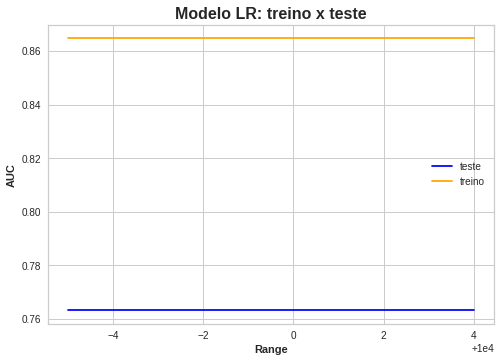

In [25]:
#plotando o gráfico LR

x = range(9995, 10005)
sns.lineplot(x, teste_lista, color="blue", label = "teste")
sns.lineplot(x, treino_lista, color="orange", label = "treino")

plt.ylabel("AUC", fontweight='bold')
plt.xlabel("Range",fontweight='bold')
plt.title("Modelo LR: treino x teste", fontsize=16,fontweight='bold')
plt.show()

In [26]:
#modificando o "max_depth" para o modelo de Árvore de Decisão

teste_lista = []
treino_lista = []

for i in range(1, 15):
  modelo_DTC = DecisionTreeClassifier(max_depth=i) #o "max_depth" é o máximo de profundidade da árvore
  teste, treino = roda_modelo_cv(modelo_DTC, dados_limpos, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC Médio: 0.5695149844820897 
 Intervalo: 0.5029131545771597 - 0.6361168143870197 

AUC Médio Treino: 0.645991601559342
AUC Médio: 0.6586237351286693 
 Intervalo: 0.5339695313706009 - 0.7832779388867378 

AUC Médio Treino: 0.7568924718583468
AUC Médio: 0.6721067179619813 
 Intervalo: 0.5502182468714534 - 0.7939951890525092 

AUC Médio Treino: 0.8272649684081176
AUC Médio: 0.668497167173154 
 Intervalo: 0.5235125994824539 - 0.8134817348638541 

AUC Médio Treino: 0.8876183463223921
AUC Médio: 0.6574598379779301 
 Intervalo: 0.517291763696655 - 0.7976279122592052 

AUC Médio Treino: 0.9321367038402493
AUC Médio: 0.6397524071619467 
 Intervalo: 0.4891518224467848 - 0.7903529918771086 

AUC Médio Treino: 0.9603819598643609
AUC Médio: 0.619786999170223 
 Intervalo: 0.49005199073760947 - 0.7495220076028364 

AUC Médio Treino: 0.9765597404176951
AUC Médio: 0.6047455641945774 
 Intervalo: 0.4732660317763395 - 0.7362250966128152 

AUC Médio Treino: 0.985396642476003
AUC Médio: 0.601826850025863

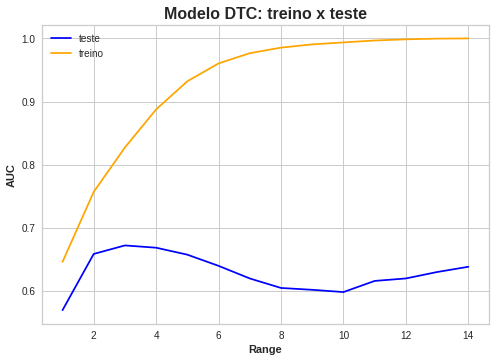

In [27]:
#plotando o gráfico DTC

x = range(1, 15)
sns.lineplot(x, teste_lista, color="blue", label = "teste")
sns.lineplot(x, treino_lista, color="orange", label = "treino")

plt.ylabel("AUC", fontweight='bold')
plt.xlabel("Range",fontweight='bold')
plt.title("Modelo DTC: treino x teste", fontsize=16,fontweight='bold')
plt.show()

In [28]:
#modificando o "max_depth" para o modelo Random Forest

teste_lista = []
treino_lista = []

for i in range(1, 5):
  modelo_RFC = RandomForestClassifier(n_estimators=200, max_depth=i) 
  teste, treino = roda_modelo_cv(modelo_RFC, dados_limpos, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC Médio: 0.7734531795551532 
 Intervalo: 0.6721672973442481 - 0.8747390617660584 

AUC Médio Treino: 0.8567331732368219
AUC Médio: 0.7858907172722964 
 Intervalo: 0.6851503148581085 - 0.8866311196864843 

AUC Médio Treino: 0.8991302440877403
AUC Médio: 0.795327384801069 
 Intervalo: 0.6928387341632225 - 0.8978160354389155 

AUC Médio Treino: 0.9408147667874153
AUC Médio: 0.7966285050002155 
 Intervalo: 0.6954135942153692 - 0.8978434157850619 

AUC Médio Treino: 0.97247008078541


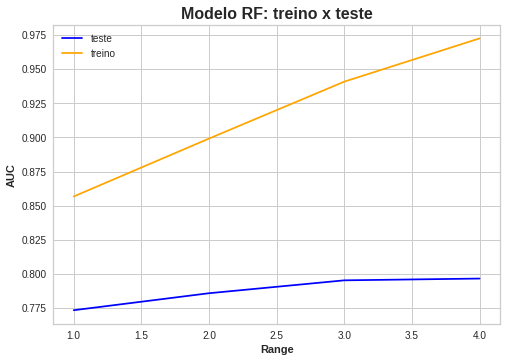

In [29]:
#plotando o gráfico RF

x = range(1, 5)
sns.lineplot(x, teste_lista, color="blue", label = "teste")
sns.lineplot(x, treino_lista, color="orange", label = "treino")

plt.ylabel("AUC", fontweight='bold')
plt.xlabel("Range",fontweight='bold')
plt.title("Modelo RF: treino x teste", fontsize=16,fontweight='bold')
plt.show()

In [30]:
#modificando o "max_depth" para o modelo ExtraTreesClassifier

teste_lista = []
treino_lista = []

for i in range(1, 5):
  modelo_ETC = ExtraTreesClassifier(max_depth=i)
  teste, treino = roda_modelo_cv(modelo_ETC, dados_limpos, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC Médio: 0.7815715453791111 
 Intervalo: 0.6966634867783504 - 0.8664796039798718 

AUC Médio Treino: 0.8327383532371779
AUC Médio: 0.7884941161256953 
 Intervalo: 0.7146472864247511 - 0.8623409458266396 

AUC Médio Treino: 0.8639818099280236
AUC Médio: 0.7905283902323375 
 Intervalo: 0.7175146154643497 - 0.8635421650003252 

AUC Médio Treino: 0.9036842243415603
AUC Médio: 0.7919881514289409 
 Intervalo: 0.7244232355248904 - 0.8595530673329913 

AUC Médio Treino: 0.9400475331908692


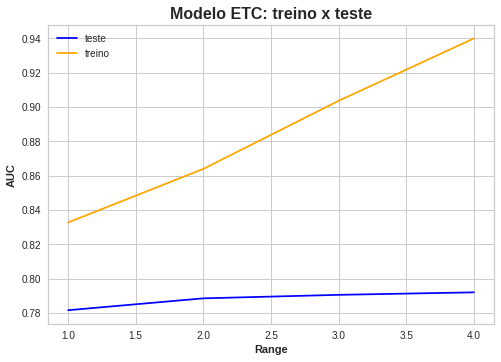

In [31]:
#plotando o gráfico ETC

x = range(1, 5)
sns.lineplot(x, teste_lista, color="blue", label = "teste")
sns.lineplot(x, treino_lista, color="orange", label = "treino")

plt.ylabel("AUC", fontweight='bold')
plt.xlabel("Range",fontweight='bold')
plt.title("Modelo ETC: treino x teste", fontsize=16,fontweight='bold')
plt.show()

<p align = "justify">Conforme verificamos nos gráficos acima, dos nossos quatro modelos testados, os que mais apresentam OVERFIT são o "Decision Tree" e o "Extra Trees". O OVERFIT ocorre quando o modelo apresenta ótima performance em separar os dados gerais através dos dados de treino, e por este motivo não consegue generalizar para os dados de teste. É possível ainda verificar que o modelo "Decision Tree" é mais sensível ao OVERFIT. O modelo que apresentou maior estabilidade foi o "Regrressão Logística".</p>

<p align = "justify">A título de explicação generalizada do que seria o OVERFIT, poderíamos dizer que o modelo se "vicia" nos dados de treino, tornando-se complexo, perdendo a capacidade de generalizar.</p>

---
##2ª ETAPA: removendo as *labels* com alta correlação

Nesse ponto do projeto faremos uma separação dos dados, com o objetivo de eliminar dados altamente correlacionados para otimizar o modelo. 

In [32]:
#gerando a matriz de correlação dos dados limpos

dados_limpos.corr()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
PATIENT_VISIT_IDENTIFIER,1.000000,-0.017361,0.031159,0.071961,0.058683,0.022828,0.045907,-0.026074,-0.005678,0.021964,0.024226,0.010275,-0.023086,-0.016204,-0.016204,-0.016204,-0.016204,NaN,0.060057,0.060057,0.060057,0.060057,NaN,0.012442,0.012442,0.012442,0.012442,NaN,0.062804,0.062804,0.062804,0.062804,NaN,0.029109,0.029109,0.029109,0.029109,NaN,0.018022,0.018022,...,-0.047713,-0.047713,NaN,0.095052,0.074880,0.076525,0.021779,-0.011847,-0.023686,0.093877,0.069839,0.077927,0.002525,-0.014158,-0.024354,0.096918,0.096265,0.081255,0.043287,0.000536,-0.014310,0.077751,0.057881,0.063673,0.015626,-0.020210,-0.024753,-0.040615,-0.082139,-0.038959,-0.046410,-0.045353,-0.018859,-0.051978,-0.080779,-0.059587,-0.030755,-0.045456,-0.015996,-0.041382
AGE_ABOVE65,-0.017361,1.000000,0.874773,0.031830,0.280326,0.051308,0.165905,0.032608,0.314536,0.003930,0.330744,0.169178,0.137186,-0.111907,-0.111907,-0.111907,-0.111907,NaN,0.069056,0.069056,0.069056,0.069056,NaN,0.097612,0.097612,0.097612,0.097612,NaN,0.018202,0.018202,0.018202,0.018202,NaN,0.054441,0.054441,0.054441,0.054441,NaN,0.021730,0.021730,...,0.071340,0.071340,NaN,-0.146802,0.222891,-0.223129,0.104568,-0.086413,-0.109800,-0.148504,0.220684,-0.207480,0.100707,-0.083182,-0.101247,-0.125120,0.221515,-0.232097,0.101549,-0.093789,-0.100968,-0.138507,0.210206,-0.222678,0.092669,-0.076399,-0.119952,-0.012655,-0.026278,0.012440,-0.005558,0.028262,-0.030515,0.009262,-0.039387,0.002790,-0.021190,0.029317,-0.031404,0.291010
AGE_PERCENTIL,0.031159,0.874773,1.000000,0.056211,0.294671,0.058015,0.134016,0.014480,0.334920,-0.035015,0.324703,0.201001,0.146246,-0.136709,-0.136709,-0.136709,-0.136709,NaN,0.046929,0.046929,0.046929,0.046929,NaN,0.147365,0.147365,0.147365,0.147365,NaN,0.000752,0.000752,0.000752,0.000752,NaN,0.031365,0.031365,0.031365,0.031365,NaN,0.015729,0.015729,...,0.063952,0.063952,NaN,-0.140119,0.269342,-0.201195,0.186620,-0.057003,-0.126255,-0.147229,0.265043,-0.186933,0.182667,-0.055100,-0.120971,-0.115272,0.272013,-0.204079,0.182024,-0.055767,-0.111780,-0.129059,0.249877,-0.208085,0.167176,-0.055859,-0.136280,-0.014140,-0.049698,-0.018826,-0.007992,-0.006030,-0.040314,0.013580,-0.062474,-0.037260,-0.040807,-0.004185,-0.039724,0.351071
GENDER,0.071961,0.031830,0.056211,1.000000,0.036528,-0.001784,-0.064757,-0.069768,-0.019812,-0.020573,-0.013136,-0.026982,0.054201,-0.089776,-0.089776,-0.089776,-0.089776,NaN,-0.018091,-0.018091,-0.018091,-0.018091,NaN,0.018961,0.018961,0.018961,0.018961,NaN,0.039055,0.0390

In [33]:
#exibindo as informações dos dados originais

dados_limpos.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 352 entries, (0, 0) to (384, 1920)
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), int8(1), object(1)
memory usage: 659.8+ KB


<p align = "justify">Vamos agora selecionar qual coluna tirar e qual deixar, da base de dados, para posteriormmente rodar novamente os modelos. Em princípio iremos remover as colunas que não fazem sentido fazer correlação.</p>

<p align = "justify">Nesse ponto do projeto é importante mencionar que somente calcular a correlação não adiantaria, sendo necessário removê-las também. Na tabela anteriormente exposta (dados_limpos.corr), é possível verificar que as altas correlações se aproximam dos valores limites, que são -1 e +1.</p>

Exemplificando:


<p align = "justify">Correlação -1: variáveis altamente correlacionadas, sendo que, quando uma cresce, a outra diminui (inversamente proporcionais);</p>

<p align = "justify">Correlação +1: variáveis altamente correlacionadas, sendo que ambas crescem na mesma proporção (diretamente proporcionais).</p>


###Reorganizando os dados

In [34]:
#criando e aplicando uma função para organizar esse processo de exclusão

def remove_corr_var(dados, valor_corte):

  matrix_corr = dados.iloc[:, 4:-2].corr().abs() #slice nas colunas que serão removidas (as que não são "float64") e normalizando para mostrar somente valores absolutos
  matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool)) #matriz de correlação: 
                                                                                              #excluindo a diagonal principal e eliminando o triângulo inferior da diagonal principal (para não excluir duas colunas altamente correlacionadas entre si)
                                                                                              #com o parâmetro "k=1" eliminamos também a diagonal principal
                                                                                              #com o parâmetro "bool" temos nossa matriz de True e False da forma que precisamos, com a mesma dimensão da matriz de correlação
  excluir = [coluna for coluna in matrix_corr.columns if any(matrix_upper[coluna] > valor_corte)] #com este procedimento vamos verificar cada uma de nossas colunas com alta correlação, a serem excluídas

  return dados.drop(excluir, axis=1) #retorna um novo dataframe "dropando", os dados das colunas que definimos excluir

In [35]:
#utilizando a função criada, vamos selecionar qual coluna tirar e qual deixar no nosso modelo

dados_limpos_sem_corr = remove_corr_var(dados_limpos, 0.95) #valor de corte considerado de 0.95
dados_limpos_sem_corr 

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,...,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.183673,-1.0,-0.868365,-1.0,-0.742004,-1.0,-0.945093,-1.0,-0.891993,-1.0,0.090147,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.540721,-1.0,-0.518519,-1.0,0.939394,-1.0,0.345679,-1.0,-0.028571,-1.0,-0.997201,-1.0,-0.990854,-1.0,-0.825613,-1.0,-0.836145,-1.0,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.912243,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.780261,-1.0,0.144654,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.399199,-1.0,-0.703704,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.995428,-1.0,-0.986662,-1.0,-0.846633,-1.0,-0.836145,-1.0,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.972789,-1.0,-1.0,-1.0,0.326531,-1.0,-0.968861,-1.0,-0.194030,-1.0,-0.316589,-1.0,-0.891993,-1.0,-0.203354,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.564753,-1.0,-0.777778,-1.0,0.939394,-1.0,0.580247,-1.0,0.200000,-1.0,-0.989549,-1.0,-0.956555,-1.0,-0.846633,-1.0,-0.937349,-1.0,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.935113,-1.0,-1.0,-1.0,0.357143,-1.0,-0.913659,-1.0,-0.829424,-1.0,-0.938084,-1.0,-0.851024,-1.0,0.358491,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.457944,-1.0,-0.592593,-1.0,0.939394,-1.0,0.345679,-1.0,0.142857,-1.0,-0.998507,-1.0,-0.991235,-1.0,-0.846633,-1.0,-0.903614,-1.0,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0-2,0
5,25,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.891012,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.891993,-1.0,0.291405,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.292390,-1.0,-0.666667,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.997947,-1.0,-0.988948,-1.0,-0.

In [36]:
#informações dos dados sem correlação

dados_limpos_sem_corr.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 352 entries, (0, 0) to (384, 1920)
Data columns (total 100 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PATIENT_VISIT_IDENTIFIER      352 non-null    int64  
 1   AGE_ABOVE65                   352 non-null    int64  
 2   AGE_PERCENTIL                 352 non-null    int8   
 3   GENDER                        352 non-null    int64  
 4   DISEASE GROUPING 1            352 non-null    float64
 5   DISEASE GROUPING 2            352 non-null    float64
 6   DISEASE GROUPING 3            352 non-null    float64
 7   DISEASE GROUPING 4            352 non-null    float64
 8   DISEASE GROUPING 5            352 non-null    float64
 9   DISEASE GROUPING 6            352 non-null    float64
 10  HTN                           352 non-null    float64
 11  IMMUNOCOMPROMISED             352 non-null    float64
 12  OTHER                         352 non-null    floa

<p align = "justify">Observando o resultado acima, verificamos que mais da metade da base de dados foi excluída. Mas este é um procedimento necessário, em razão dos dados altamente correlacionados possivelmente interferirem na eficácia do modelo.</p>

###Rodando novamente os modelos

In [37]:
#agora vamos testar o modelo (depois das colunas excluídas)

roda_modelo_cv(modelo_LR, dados_limpos_sem_corr, 5, 10)

AUC Médio: 0.770929498577525 
 Intervalo: 0.6827362771312062 - 0.8591227200238438 

AUC Médio Treino: 0.849255054128128


(0.770929498577525, 0.849255054128128)

In [38]:
#agora vamos testar o modelo (depois das colunas excluídas)

roda_modelo_cv(modelo_DTC, dados_limpos_sem_corr, 5, 10)

AUC Médio: 0.6323255110672875 
 Intervalo: 0.5046395693604554 - 0.7600114527741196 

AUC Médio Treino: 0.9998292067368453


(0.6323255110672875, 0.9998292067368453)

In [39]:
#agora vamos testar o modelo (depois das colunas excluídas)

roda_modelo_cv(modelo_RFC, dados_limpos_sem_corr, 5, 10)

AUC Médio: 0.8077783659856028 
 Intervalo: 0.7082301151345699 - 0.9073266168366357 

AUC Médio Treino: 0.9664735791635002


(0.8077783659856028, 0.9664735791635002)

In [40]:
#agora vamos testar o modelo (depois das colunas excluídas)

roda_modelo_cv(modelo_ETC, dados_limpos_sem_corr, 5, 10)

AUC Médio: 0.7796214411181518 
 Intervalo: 0.6984024952528713 - 0.8608403869834322 

AUC Médio Treino: 0.9078828015453426


(0.7796214411181518, 0.9078828015453426)

<p align = "justify">Com base nos resultados obtidos acima, verificamos uma pequena melhora quando comparado aos valores gerados anteriormente pelos modelos, com exceção do modelo ETC (Extra Trees), que teve leve redução no desempenho. O modelo que apresentou melhor resultado, comparado com os demais utilizados nesse estudo, foi o "Random Forest" (RF).</p> 




###Matriz de Confusão

<p align = "justify">Vamos analisar novamente os gráficos da Matriz de Confusão, utilizando agora os dados sem as correlações, a fim de comparar com os resultados obtidos ao longo dos testes realizados anteriormente.</p>

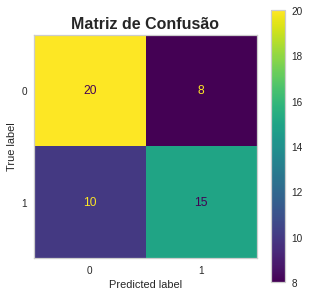

In [41]:
#plotando os valores preditos (usando uma matriz de confusão) - a acurácia é a diagonal
# Modelo Logísitic Regression

matriz_confusao(modelo_LR, dados_limpos_sem_corr)

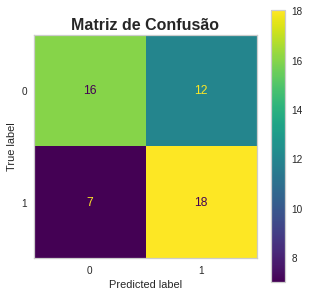

In [42]:
#plotando os valores preditos (usando uma matriz de confusão) - a acurácia é a diagonal
# Modelo Decision Tree

matriz_confusao(modelo_DTC, dados_limpos_sem_corr)

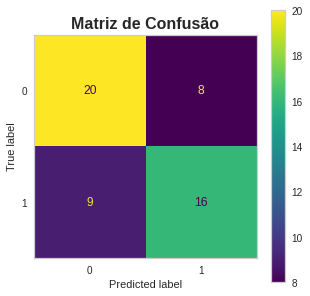

In [43]:
#plotando os valores preditos (usando uma matriz de confusão) - a acurácia é a diagonal
# Modelo Random Forest

matriz_confusao(modelo_RFC, dados_limpos_sem_corr)

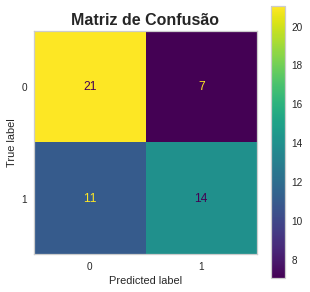

In [44]:
#plotando os valores preditos (usando uma matriz de confusão) - a acurácia é a diagonal
# Modelo Extra Trees

matriz_confusao(modelo_ETC, dados_limpos_sem_corr)

<p align = "justify">Conforme podemos ver nos resultados acima, o modelo que apresentou melhor desempenho, se compararmos a relação entre "Verdadeiros Positivos" (que identifica maiores acertos) e "Falsos Negativos" (que identifica menor quantidade de erros), que é de fato o aspecto mais importante no estudo em tela, foi o "Random Forest". Em segundo lugar ficou o modelo de Regressão Logística.</p>

<p align = "justify">Para analisar a eficácia do modelo é importante realizar um balanceamento entre o que ele indica como tendo acertado e o que ele indica ter errado. Nesse caso, o Modelo "Random Forest" foi o que mais acerto, se considerarmos a diagonal de acurácia ("Verdadeiros Positivos" e "Verdadeiros Netativos"), e o que menos errou, se considerarmos a outra diagonal (de "Falsos Negativos" e "Falsos Positivos").</p>

###Plotando o gráfico da Curva ROC_AUC

In [45]:
#criando a função para plotar a curva ROC_AUC

def plota_ROC(modelo, dados):

  y = dados["ICU"] #preparando variáveis de treino e teste para os modelos
  x = dados.drop(["ICU","WINDOW"], axis=1)

  np.random.seed(93578) #gerando uma "semente" para reproduzir novamente os resultados obtidos

  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.15) #o "test_size=0.15" reduz um pouco o conjunto de dados para treino

  modelo.fit(x_train, y_train)
  predicao = modelo.predict(x_test)

  fig, ax = plt.subplots(figsize=(9,9))
  roc_viz = ROCAUC(modelo)
  roc_viz.score(x_test, y_test) 
  plt.legend()
  ax.set_ylabel("Taxa de VP", fontsize=18)
  ax.set_xlabel("Taxa de FP", fontsize=18)
  plt.title(f"Curva ROC - Modelo {modelo.__class__.__name__}", fontsize=20, loc='left', weight='bold')
  plt.show()

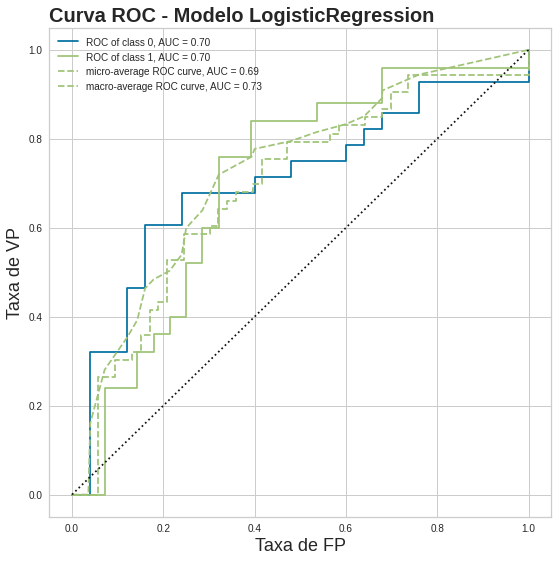

In [46]:
plota_ROC(modelo_LR, dados_limpos_sem_corr)

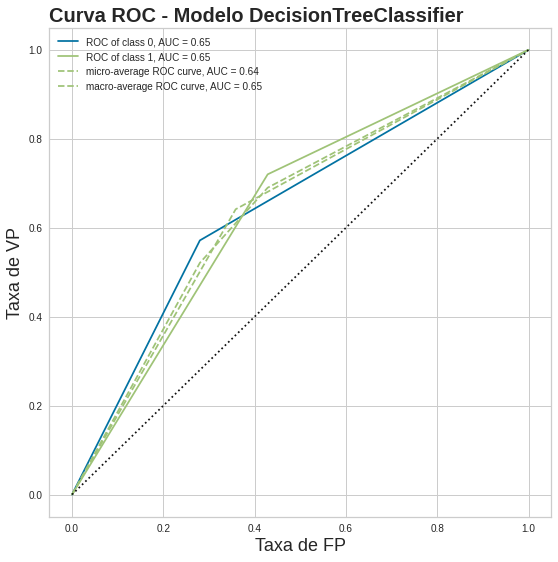

In [47]:
plota_ROC(modelo_DTC, dados_limpos_sem_corr)

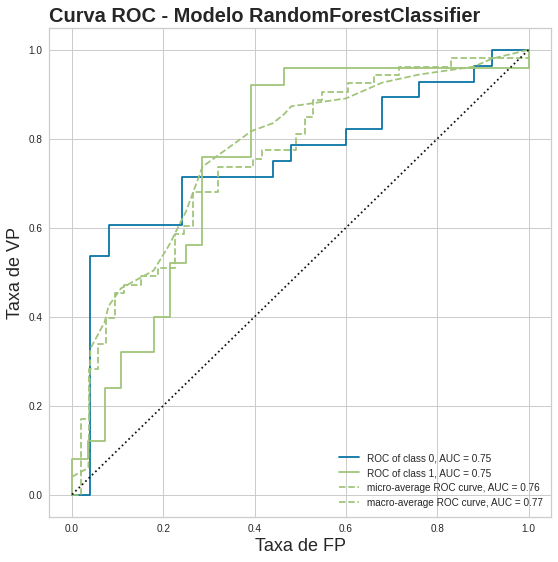

In [48]:
plota_ROC(modelo_RFC, dados_limpos_sem_corr)

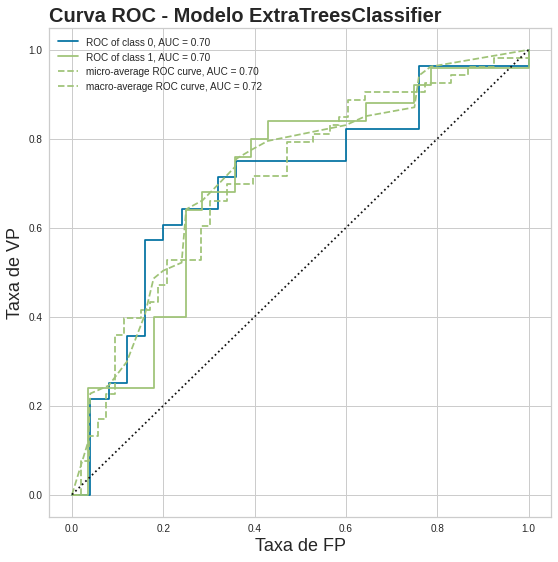

In [49]:
plota_ROC(modelo_ETC, dados_limpos_sem_corr)

<p align = "justify">Como visto acima, o modelo Random Forest continua apresentando os melhores resultados, motivo pelo qual será o escolhido neste projeto. 

---



#CONCLUSÃO

<p align = "justify">Quando então chegamos ao final deste notebook, com um modelo escolhido, pensamos ainda em várias possibilidades que poderíamos ter explorado. Entretando, a partir do restultado obtido, gostaríamos de comentar certos aspectos do projeto.</p>

Com relação ao modelo escolhido, Random Forest, o que nos levou a essa conclusão foi a análise em conjunto de todos os dados obtidos ao longo do estudo, não tendo sido realizada uma análise isolada. 

<p align = "justify">Fica evidente que não podemos adotar parâmetros isolados, e isso é o mais importante. A análise deve ser ampla e realizada em conjunto com os dados obtidos através de ferramentas e métodos diversos. Baseando-se apenas nas ferrametas utilizadas, chegamos a esta conclusão. Outras ferramentas melhores existem e serão certamente utilizadas em momento oportuno. Por hora, com base no conhecimento que adquirimos nos últimos meses, acreditamos se tratar de um nível de resultado satisfatório, embora saibamos que este modelo acaba por servir como exercício, não estando pronto para entrar em produção.</P>

<p align = "justify">Ao longo dos vários testes realizados durante a implementação deste projeto, podemos perceber quão ampla é a aplicabilidade das diversas ferramentas utilizadas para a previsão de resultados, no caso, Machine Learning. A área é vasta e estamos dando os primeiros passos, nos aventurando nesse campo largamente técnico e, ao mesmo tempo, que tem como requisito habilidades diversas para a interpretação dos resultados obtidos. Esperamos ter conseguido interpretar de forma adequada os resultados, mas sabemos que há ainda muito por fazer. Certamente há outras formas e métodos que poderão ainda ampliar a acurácia dos modelos, técnicas estas que pretendemos nos debruçar e explorar com maior atenção e enpenho num futuro próximo.</p>

#REFERÊNCIAS

Alguams fontes consultadas, além dos materiais de aula:

https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/

https://medium.com/@itbodhi/overfitting-and-underfitting-in-machine-learning-models-76cb60dbdaf6

https://docs.microsoft.com/pt-br/azure/machine-learning/how-to-understand-automated-ml

https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc#slideDown

https://valquiria-c-alencar.medium.com/machine-learning-na-sa%C3%BAde-prevendo-a-necessidade-de-interna%C3%A7%C3%A3o-em-leitos-de-uti-durante-a-pandemia-c7c274a623b6

[Notebooks das aulas (Bootcamp Alura)](https://github.com/gcochlar/Bootcamp_DataScience)